### Import Libraries

In [1]:
import gym
import gym.spaces
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
#SELECT GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    #Change reshape to return flattened vector
    return np.reshape(image.astype(np.float).ravel(), [80,80]).reshape(-1)

### Create  game environment and examine action space

In [3]:
env = gym.make("Pong-v0") #choose the game

obs = env.reset()


In [4]:
env.action_space

Discrete(6)

### Data loading

In [5]:
reward_file = 'reward_trend124.npy'
win_file = 'win_trend124.npy'


# hyperparameters
H1 = 200 # number of hidden layer neurons
H2 = 200
learning_rate = 0.0005
gamma = 0.99 # discount factor for reward

epochs = 900000 # Reduce to reasonable number if don't intend to manually stop

# model initialization
D = 80 # input dimensionality of one image
C = 2 # class number

def policy_gradient():
''' Function to create tensorflow graph for policy gradient network'''
    with tf.variable_scope("policy"):
        state = tf.placeholder(tf.float32, [None, D*D])
        actions = tf.placeholder(tf.int32, [None, 1])
        rewards = tf.placeholder(tf.float32, [None, 1])
        
        #One Relu layer with 200 neurons, 1 sigmoid predicting probability of going "Right"
        hidden_lyr1 = tf.layers.dense(activation=tf.nn.relu, inputs= state, units=H1, \
                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
        output_lyr = tf.layers.dense(activation=tf.sigmoid, inputs = hidden_lyr1, units = 1, \
                                    kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        
        probabilities = output_lyr
        #Log loss giving high weights to actions that result in more reward
        loss = tf.losses.log_loss(
            labels=actions,
            predictions=output_lyr,
            weights=rewards,
            epsilon=1e-7)
        #ADAM optimizer to minimize logloss
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
        return probabilities, state, actions, rewards, optimizer

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    #NORMALIZE REWARDS BY TAKING MEAN/SD
    discounted_r -= np.mean(discounted_r)
    discounted_r /= np.std(discounted_r)
    return discounted_r

def choose_action(prob):
    probs = np.concatenate([1-prob, prob])
    action = np.random.choice(range(len(probs)), p=probs)  # select action w.r.t the actions prob
    return action

def baseline():
    with tf.variable_scope("baseline"):
        state = tf.placeholder(tf.float32, [None, D*D])
        actions = tf.placeholder(tf.int32, [None, 1])
        expected_rewards = tf.placeholder(tf.float32, [None,])
        #misnomer because it trains on actual discounted rewards so the policy network can use expected rewards.

        #2 fully connected relu layers, one linear output layer.
        hidden_lyr1 = tf.layers.dense(activation=tf.nn.leaky_relu, inputs= state, units=H1, \
                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
        #hidden = tf.nn.relu(tf.matmul(state, params_w1) + params_b1)
        hidden_lyr2 = tf.layers.dense(activation=tf.nn.relu, inputs= hidden_lyr1, units=H2,\
                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
        output_lyr = tf.layers.dense(activation=None, inputs = hidden_lyr2, units = 1, \
                                    kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        
        
        #Square error loss
        loss = tf.reduce_mean(tf.square(output_lyr - expected_rewards), name="mse")

        optimizer = tf.train.AdamOptimizer(learning_rate*1.2).minimize(loss)
        return output_lyr, state, actions, expected_rewards, optimizer



policy_grad = policy_gradient()
baseline_obj = baseline()

sess = tf.InteractiveSession() 
init = tf.global_variables_initializer()
sess.run(init)



reward_sum = 0
reward_trend = []
wins_trend = []
totepisodes = 0
for epoch in range(epochs):
    pl_calculated, pl_state, pl_actions, pl_advantages, pl_optimizer = policy_grad
    bl_calculated, bl_state, bl_actions, bl_advantages, bl_optimizer = baseline_obj
    feed_states, feed_actions, feed_reward, feed_advantages = [], [], [], []
    #Batch size of 2 episodes
    for episode_number in range(2):
        feed_reward = []
        observation2 = env.reset()
       
        reward_sum = 0
        
        observation = np.zeros(D*D)
        observation2 = preprocess(observation2)
        old_obs = None
        #Run till end of each episode
        while True:
            #STATE IS CHANGE BETWEEN CONSECUTIVE FRAMES
            full_obs = observation2 - observation
            
            state = np.copy(full_obs) #shape (D*D)
            #Use policy network to get action probability
            aprob = sess.run(pl_calculated, feed_dict={pl_state: np.reshape(state, (1, D*D))}) # aprob's shape: 1 * Cnp.reshape(state, (1, D*D)
            action = choose_action(aprob[0]) + 2 # select an action based on policy gradient - Plus 2 to make action 2 or 3
            feed_states.append(state)
            #Store 0-1 actions instead of 2-3
            feed_actions.append(action - 2)
            #Reset observation
            observation = np.copy(observation2)
            # step the environment and get new measurements
            observation2, reward, done, info = env.step(action)
            observation2 = preprocess(observation2)
            
            reward_sum += reward
            feed_reward.append(reward)

            if done: # an episode finished
                if totepisodes % 50 == 0:
                    print("episode is done")
                    print("reward_sum: {}".format(reward_sum))

                    
                    np.save(reward_file,np.array(reward_trend))
                    np.save(win_file,np.array(wins_trend))
                    print("episode %d, reward_sum %.2f, number of steps %d, number of wins %d, number of losses %d" \
                          % (totepisodes,reward_sum, len(feed_reward), feed_reward.count(1),feed_reward.count(-1)))


                reward_trend.append(reward_sum)
                wins_trend.append(feed_reward.count(1))
                feed_advantages.append(discount_rewards(feed_reward)) # compute discounted and normalized rewards
                totepisodes  += 1

                break
            
    
    #Get Expected reward from state through baseline network
    bl_adj = sess.run(bl_calculated, feed_dict={bl_state: np.stack(feed_states, axis=0), \
                                      })
    
    feed_advantages = np.concatenate(feed_advantages)
    #Subtract baseline adjustment to reduce variance without affecting bias
    exp_adj_rewards = feed_advantages - np.hstack(bl_adj)
    
    
    #Train baseline with current rewards
    sess.run(bl_optimizer, feed_dict={bl_state: np.stack(feed_states, axis=0), \
                                      bl_advantages: feed_advantages})

    #Train policy network with adjusted rewards
    sess.run(pl_optimizer, feed_dict={pl_state: np.stack(feed_states, axis=0), \
                                      pl_advantages: np.vstack(exp_adj_rewards), pl_actions: np.vstack(feed_actions)})

#Plot performance curve when done    
plt.clf()
plt.plot(reward_trend, color = 'blue')
plt.plot(np.convolve(reward_trend, np.ones((10,))/10, mode='valid'),color = 'red')
plt.title('Pong Reward vs. Episode')
plt.savefig('Pong_reward_trend.png')

plt.show()


episode is done
reward_sum: -21.0
episode 0, reward_sum -21.00, number of steps 1347, number of wins 0, number of losses 21
episode is done
reward_sum: -20.0
episode 50, reward_sum -20.00, number of steps 1380, number of wins 1, number of losses 21
episode is done
reward_sum: -20.0
episode 100, reward_sum -20.00, number of steps 1229, number of wins 1, number of losses 21
episode is done
reward_sum: -21.0
episode 150, reward_sum -21.00, number of steps 1415, number of wins 0, number of losses 21
episode is done
reward_sum: -20.0
episode 200, reward_sum -20.00, number of steps 1470, number of wins 1, number of losses 21
episode is done
reward_sum: -21.0
episode 250, reward_sum -21.00, number of steps 1663, number of wins 0, number of losses 21
episode is done
reward_sum: -20.0
episode 300, reward_sum -20.00, number of steps 1322, number of wins 1, number of losses 21
episode is done
reward_sum: -20.0
episode 350, reward_sum -20.00, number of steps 2033, number of wins 1, number of losse

episode is done
reward_sum: -17.0
episode 3250, reward_sum -17.00, number of steps 3547, number of wins 4, number of losses 21
episode is done
reward_sum: -1.0
episode 3300, reward_sum -1.00, number of steps 7440, number of wins 20, number of losses 21
episode is done
reward_sum: -13.0
episode 3350, reward_sum -13.00, number of steps 5929, number of wins 8, number of losses 21
episode is done
reward_sum: -11.0
episode 3400, reward_sum -11.00, number of steps 5713, number of wins 10, number of losses 21
episode is done
reward_sum: -7.0
episode 3450, reward_sum -7.00, number of steps 6867, number of wins 14, number of losses 21
episode is done
reward_sum: -8.0
episode 3500, reward_sum -8.00, number of steps 6075, number of wins 13, number of losses 21
episode is done
reward_sum: -12.0
episode 3550, reward_sum -12.00, number of steps 5073, number of wins 9, number of losses 21
episode is done
reward_sum: -5.0
episode 3600, reward_sum -5.00, number of steps 7742, number of wins 16, number 

episode is done
reward_sum: -9.0
episode 6550, reward_sum -9.00, number of steps 6257, number of wins 12, number of losses 21
episode is done
reward_sum: -1.0
episode 6600, reward_sum -1.00, number of steps 8916, number of wins 20, number of losses 21
episode is done
reward_sum: -5.0
episode 6650, reward_sum -5.00, number of steps 6785, number of wins 16, number of losses 21
episode is done
reward_sum: -5.0
episode 6700, reward_sum -5.00, number of steps 7898, number of wins 16, number of losses 21
episode is done
reward_sum: -9.0
episode 6750, reward_sum -9.00, number of steps 8576, number of wins 12, number of losses 21
episode is done
reward_sum: 3.0
episode 6800, reward_sum 3.00, number of steps 7639, number of wins 21, number of losses 18
episode is done
reward_sum: 8.0
episode 6850, reward_sum 8.00, number of steps 7114, number of wins 21, number of losses 13
episode is done
reward_sum: -4.0
episode 6900, reward_sum -4.00, number of steps 7928, number of wins 17, number of losses

episode is done
reward_sum: 13.0
episode 9850, reward_sum 13.00, number of steps 6241, number of wins 21, number of losses 8
episode is done
reward_sum: 1.0
episode 9900, reward_sum 1.00, number of steps 7749, number of wins 21, number of losses 20
episode is done
reward_sum: 16.0
episode 9950, reward_sum 16.00, number of steps 4607, number of wins 21, number of losses 5
episode is done
reward_sum: 1.0
episode 10000, reward_sum 1.00, number of steps 8058, number of wins 21, number of losses 20
episode is done
reward_sum: 11.0
episode 10050, reward_sum 11.00, number of steps 5392, number of wins 21, number of losses 10
episode is done
reward_sum: 6.0
episode 10100, reward_sum 6.00, number of steps 8678, number of wins 21, number of losses 15
episode is done
reward_sum: 18.0
episode 10150, reward_sum 18.00, number of steps 4120, number of wins 21, number of losses 3
episode is done
reward_sum: 7.0
episode 10200, reward_sum 7.00, number of steps 9081, number of wins 21, number of losses 1

episode is done
reward_sum: 7.0
episode 13150, reward_sum 7.00, number of steps 7401, number of wins 21, number of losses 14
episode is done
reward_sum: 8.0
episode 13200, reward_sum 8.00, number of steps 6689, number of wins 21, number of losses 13
episode is done
reward_sum: 7.0
episode 13250, reward_sum 7.00, number of steps 7290, number of wins 21, number of losses 14
episode is done
reward_sum: 8.0
episode 13300, reward_sum 8.00, number of steps 7279, number of wins 21, number of losses 13
episode is done
reward_sum: 8.0
episode 13350, reward_sum 8.00, number of steps 8212, number of wins 21, number of losses 13
episode is done
reward_sum: -2.0
episode 13400, reward_sum -2.00, number of steps 8327, number of wins 19, number of losses 21
episode is done
reward_sum: 16.0
episode 13450, reward_sum 16.00, number of steps 7160, number of wins 21, number of losses 5
episode is done
reward_sum: -4.0
episode 13500, reward_sum -4.00, number of steps 7741, number of wins 17, number of losse

episode is done
reward_sum: 2.0
episode 16450, reward_sum 2.00, number of steps 9087, number of wins 21, number of losses 19
episode is done
reward_sum: 17.0
episode 16500, reward_sum 17.00, number of steps 3900, number of wins 21, number of losses 4
episode is done
reward_sum: -5.0
episode 16550, reward_sum -5.00, number of steps 8432, number of wins 16, number of losses 21
episode is done
reward_sum: 5.0
episode 16600, reward_sum 5.00, number of steps 7474, number of wins 21, number of losses 16
episode is done
reward_sum: 5.0
episode 16650, reward_sum 5.00, number of steps 7046, number of wins 21, number of losses 16
episode is done
reward_sum: 10.0
episode 16700, reward_sum 10.00, number of steps 5568, number of wins 21, number of losses 11
episode is done
reward_sum: 2.0
episode 16750, reward_sum 2.00, number of steps 8469, number of wins 21, number of losses 19
episode is done
reward_sum: 6.0
episode 16800, reward_sum 6.00, number of steps 8164, number of wins 21, number of losse

episode is done
reward_sum: 8.0
episode 19750, reward_sum 8.00, number of steps 9484, number of wins 21, number of losses 13
episode is done
reward_sum: 12.0
episode 19800, reward_sum 12.00, number of steps 6294, number of wins 21, number of losses 9
episode is done
reward_sum: 6.0
episode 19850, reward_sum 6.00, number of steps 6684, number of wins 21, number of losses 15
episode is done
reward_sum: 13.0
episode 19900, reward_sum 13.00, number of steps 5709, number of wins 21, number of losses 8
episode is done
reward_sum: 9.0
episode 19950, reward_sum 9.00, number of steps 4935, number of wins 21, number of losses 12
episode is done
reward_sum: 7.0
episode 20000, reward_sum 7.00, number of steps 7749, number of wins 21, number of losses 14
episode is done
reward_sum: 11.0
episode 20050, reward_sum 11.00, number of steps 4821, number of wins 21, number of losses 10
episode is done
reward_sum: 6.0
episode 20100, reward_sum 6.00, number of steps 7934, number of wins 21, number of losses

KeyboardInterrupt: 

In [6]:
saver = tf.train.Saver()
saver.save(sess, os.path.join("model_store", "policy_network.ckpt" ))

'model_store/policy_network.ckpt'

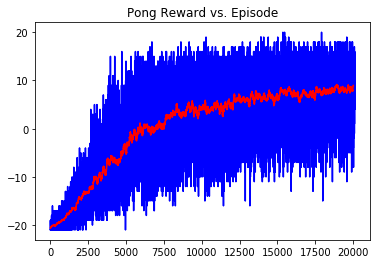

In [8]:
plt.clf()
plt.plot(reward_trend, color = 'blue')
plt.plot(np.convolve(reward_trend, np.ones((100,))/100, mode='valid'),color = 'red')
plt.title('Pong Reward vs. Episode')
plt.savefig('pong_reward_trend_stopped.png')
#plt.plot(reward_trend)
plt.show()
